# Передискретизация

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal
%matplotlib inline
from IPython.display import HTML

In [110]:
sampling = 0.1

plt.rcParams['figure.figsize'] = [11, 13]
plt.rcParams['figure.dpi'] = 100
xRange = 5
x = np.arange(-xRange, xRange, sampling)

In [111]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    return np.fft.fftfreq(len(x), d=sampling)

def flipAtOrigin(data):
    return np.concatenate([data[len(data)//2:], data[:len(data)//2],])
        

def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [112]:
def rollingAverage (data, radius = 5.0):
    radius = int(radius)
    
    out = np.zeros(len(data))
    for i in range(len(data)):
        count = 0
        sum_val = 0
        for j in range(-radius, radius):
            count+=1
            sum_val += data[i+j] if 0 <= i+j < len(data)  else 0
        out[i] = sum_val/count
    return out

In [113]:
def lowPassFilterPerfect(w, x):
    return 1.0 if np.abs(x) < w else 0

In [114]:
def lowPass(w, x, values):
    #print(len(x))
    #print(len(values))
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])

    data = np.vectorize(partial(lowPassFilterPerfect, w), otypes=[np.complex128])(freqAxis)
    fil = np.fft.ifft(data)
    fil = flipAtOrigin(fil)
    
    r_fil = rollingAverage(np.vectorize(partial(rect, 1.0))(x), 1.0)*fil
    #plt.plot(np.real(r_fil))
    filtered = np.convolve(r_fil, values, 'same')

    return filtered

In [74]:
def upsample(x, y):
    N = len(x)
    M = len(y)
    for i in range(len(y)):
        if 0<=i<=N/2:
            y[i] = x[i]
        if N/2 + M - N < i < M:
            y[i] = x[i-M+N]

#y - destination
#x - source
def downsample(x, y):
    N = len(x)
    M = len(y)
    ratio = math.ceil(N/M)
    for i in range(M):
        y[i] = x[i*ratio]
        
def lcm(a, b):
    import math
    return (a * b) // math.gcd(a, b)

def resample(data, newLen):
    fftData = FFT(data)
    
    result = np.zeros(newLen, dtype = np.complex128)
    if newLen >= len(data):
        base_f = lcm(len(data), newLen)
        print(base_f)
        scaledFt = np.zeros(base_f, dtype = np.complex128)
        upsample(fftData, scaledFt)
        result_ft = fft.ifft(scaledFt)*len(scaledFt)/len(data)
        downsample(result_ft, result)
    else:
        nearest = resample(data, lcm(len(data), newLen))

        highCutoffFreq = 0.5 / (2*xRange / newLen)

        nearest = lowPass(highCutoffFreq, np.linspace(-xRange, xRange, len(nearest)), nearest)

        downsample(nearest, result)

    return result

In [75]:
def getFreqPlot(data, label, x):
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])
    freqAxis = freqAxis[:len(freqAxis)//2]
    return {'data': np.abs(data[:len(data)//2]), 'label': label, 'x': freqAxis[:len(data)//2]}

In [76]:
def showPlots(plots):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    pid = 0
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1            
        if 'x' not in plots[i]:
            axs[pid].plot(plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        else:
            axs[pid].plot(plots[i]['x'][:len(plots[i]['data'])], plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        axs[pid].grid()
        axs[pid].legend(loc = 'upper right')
        
        pid+=1

In [77]:
def showPlotsAnim(plots):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    pid = 0
    figs = []
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1            
        if 'x' not in plots[i]:
            fg, = axs[pid].plot(plots[i]['data'][0], label = plots[i]['label'], color = colors[i%len(colors)])
            figs.append(fg)
        else:
            fg, = axs[pid].plot(plots[i]['x'][0], plots[i]['data'][0], label = plots[i]['label'], color = colors[i%len(colors)])
            figs.append(fg)
        axs[pid].grid()
        axs[pid].legend(loc = 'upper right')
        
        pid+=1
        
    for i in range(len(figs)):
        anims.append(animation.FuncAnimation(
            fig, partial(animate_f, figs[i],plots[i]['x'], plots[i]['data']), interval=200, blit=True, save_count=50))
    
    plt.show()

In [78]:
def sampleRateConv(data, newLen):
    fftData = FFT(data)
    
    
    scaled = resample(data, newLen)
    print(f"Old Sample %d – New Sample %d" % (len(data), newLen))

    showPlots([getFreqPlot(fftData, "original fft", np.linspace(-xRange, xRange, len(fftData))),
               getFreqPlot(FFT(scaled), "resampled fft", np.linspace(-xRange, xRange, len(scaled))),
               {'data': np.real(scaled), 'label': "resampled signal " + str(len(scaled)), 'x': np.linspace(-xRange, xRange, len(scaled))},
               {'data': np.real(data), 'label': "original signal " + str(len(data)), 'x': x}])

1000
Old Sample 100 – New Sample 1000


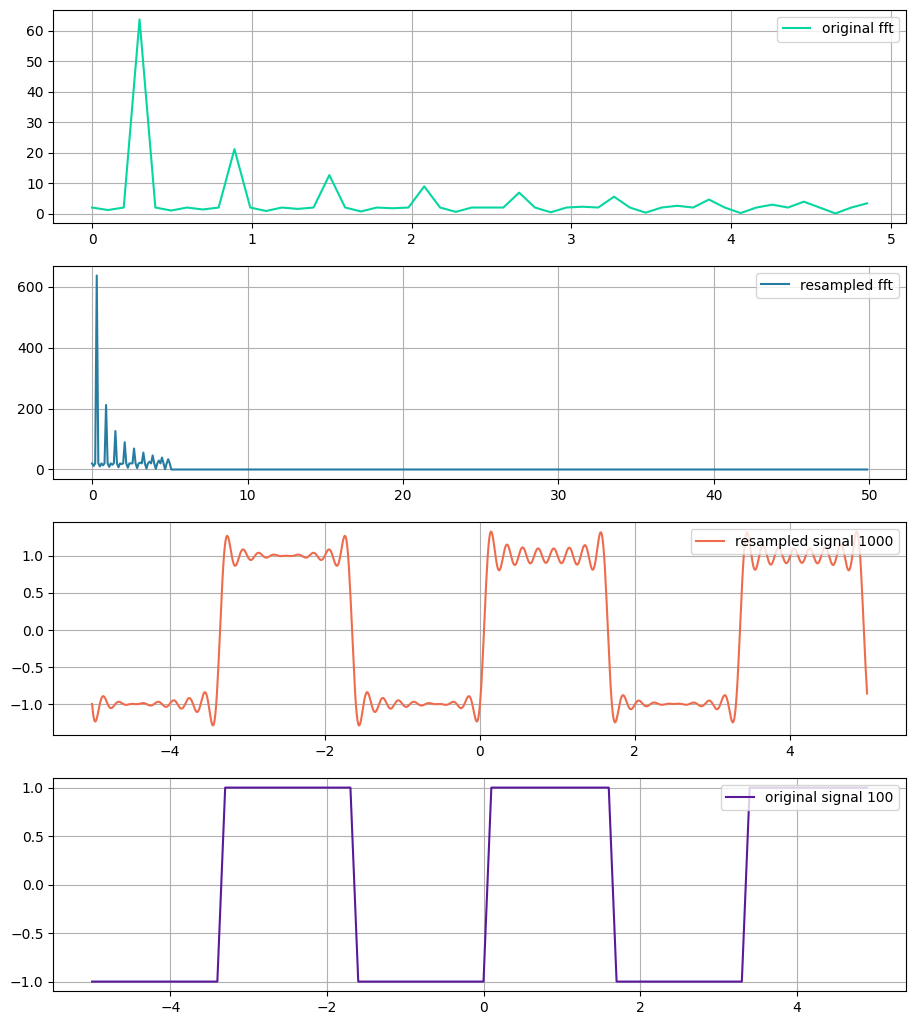

In [79]:
sampling = 0.1
x = np.arange(-xRange, xRange, sampling)

sampleRateConv(signal.square(2 * np.pi * 0.3 * x), 1000)

1001000
Old Sample 1000 – New Sample 1001


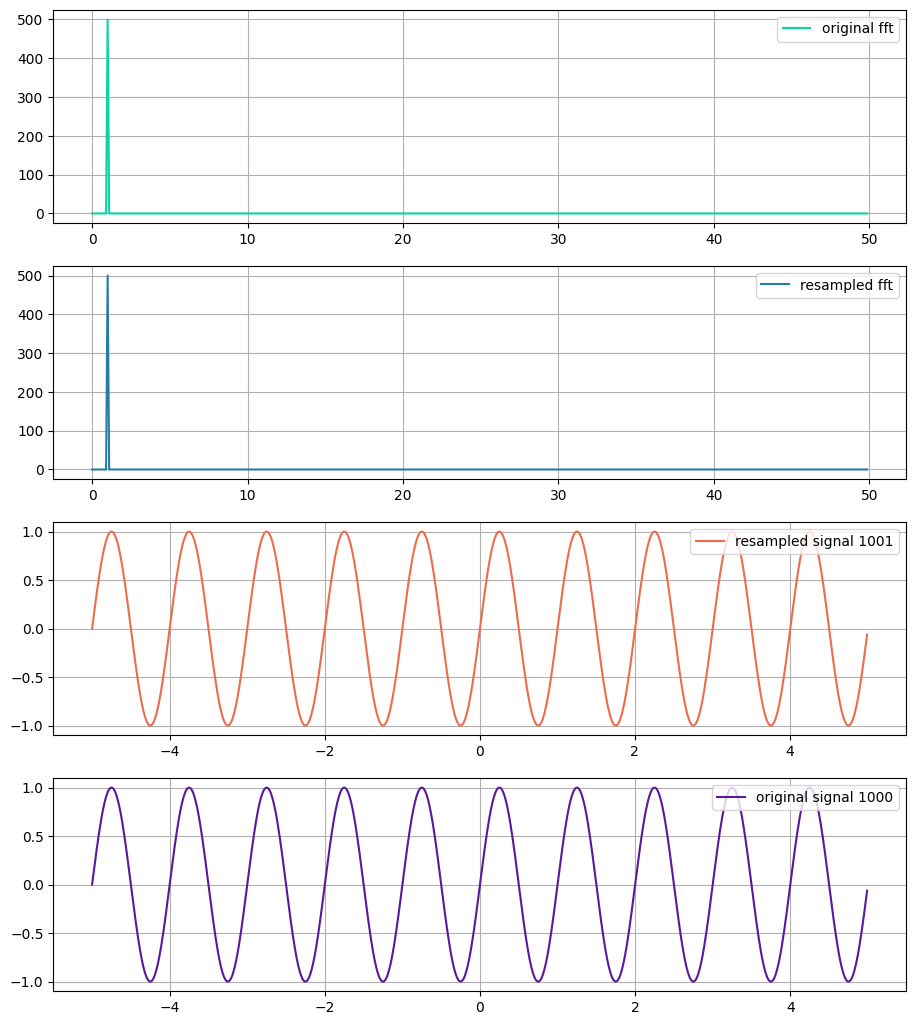

In [88]:
sampling = 0.01
x = np.arange(-xRange, xRange, sampling)

sampleRateConv(np.sin((2 * np.pi)*x), 1001)

In [89]:
def resampling(x, signal, M):
    def upSample(N, M, spectrum):
        newSpectrum = np.zeros(M, dtype = np.complex128)
        if (N%2==0):
            for i in range(0,(N+1)//2-1):
                newSpectrum[i] = spectrum[i]
            for i in range((N+1)//2, (N+1)//2+M-N-1):
                newSpectrum[i] = 0
            for i in range((N+1)//2+M-N, M-1):
                newSpectrum[i] = spectrum[i-M+N]
        else:
            for i in range(0,N//2-1):
                newSpectrum[i] = spectrum[i]
            newSpectrum[N//2] = spectrum[(N//2)]//2
            for i in range(N//2+1, N//2+M-N-1):
                newSpectrum[i] = 0
            newSpectrum[N//2+M-M] = spectrum[(N//2)]//2    
            for i in range(N//2+M-N+1, M-1):
                newSpectrum[i] = spectrum[i-M+N]
        newSpectrum = newSpectrum * M / N
        return newSpectrum
    
    N = len(signal)
    spectrum = np.fft.fft(signal)
    newX = np.arange(x[0], x[len(x)-1], (x[len(x)-1]-x[0])/M)[:M]
    tmpM = N * M // math.gcd(N,M)
    print(tmpM)
    newSpectrumTMP = upSample(N, tmpM, spectrum)
    newSignalTMP = np.fft.ifft([newSpectrumTMP[i] if (i<M/2 or i>(tmpM-M/2)) else 0 for i in range(tmpM)])
    #newSignalTMP = np.fft.ifft(newSpectrumTMP)
    newSignal = np.zeros(M)
    for i in range(M):
        newSignal[i] = newSignalTMP[int(i/M*tmpM)] 
    return newX, np.real(newSignal)

def freq(x: np.array):
    return np.fft.fftfreq(x.size, d=x[1]-x[0])

In [121]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

3000


/var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/ipykernel_59068/2739868110.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  newSignal[i] = newSignalTMP[int(i/M*tmpM)]


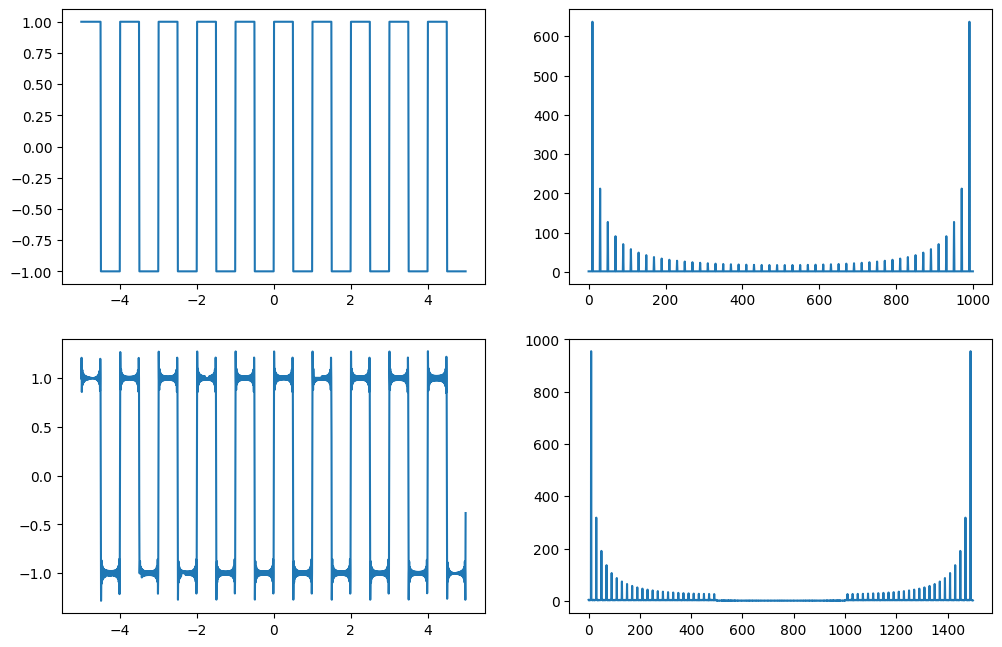

In [134]:
sampling = 0.01
x = np.arange(-xRange, xRange, sampling)
fg, ax = plt.subplots(2, 2)
my_signal = signal.square(2 * np.pi * x)
ax[0, 0].plot(x, my_signal)
ax[0, 1].plot(np.abs(np.fft.fft(my_signal)))
new_x, resampled = resampling(x, my_signal, 1500)
ax[1, 0].plot(new_x, resampled)
ax[1, 1].plot(np.abs(np.fft.fft(resampled)))

800


/var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/ipykernel_59068/2739868110.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  newSignal[i] = newSignalTMP[int(i/M*tmpM)]


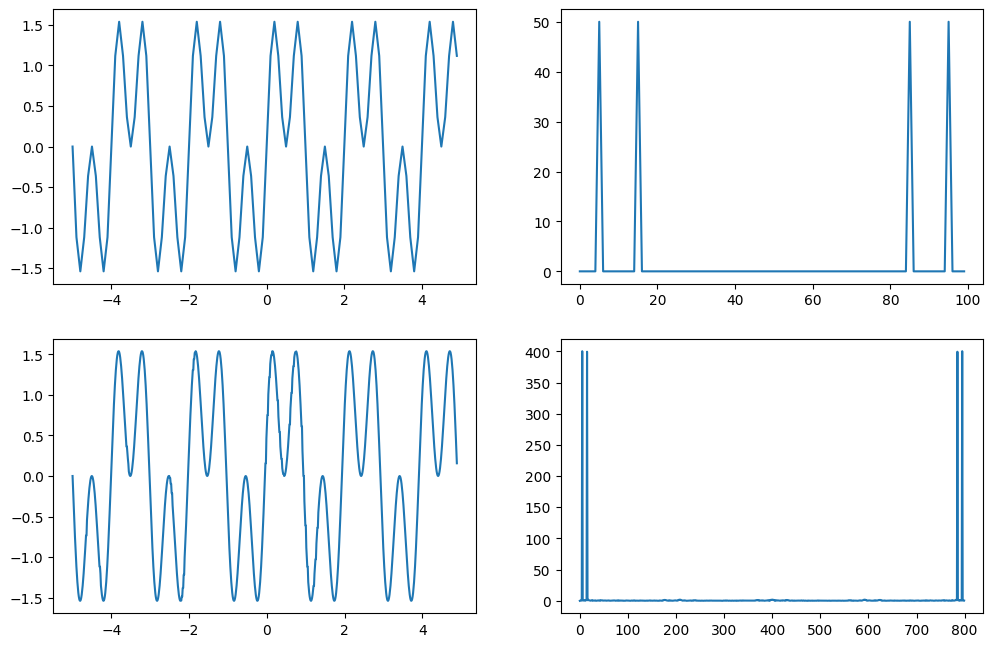

In [131]:
sampling = 0.1
x = np.arange(-xRange, xRange, sampling)
fg, ax = plt.subplots(2, 2)
my_signal = np.sin(np.pi * x) + np.sin(np.pi * x * 3)
ax[0, 0].plot(x, my_signal)
ax[0, 1].plot(np.abs(np.fft.fft(my_signal)))
new_x, resampled = resampling(x, my_signal, 800)
ax[1, 0].plot(new_x, resampled)
ax[1, 1].plot(np.abs(np.fft.fft(resampled)))